## Define Imports

In [56]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout,SimpleRNN,GRU # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
# from keras.models import Sequential
# from keras.layers import Dense, SimpleRNN , Dropout, LSTM, GRU
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
%matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
#mounting drive
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/Deep_Learning/MSFT.csv'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.preprocessing import MinMaxScaler

In [57]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import yfinance as yf
# Setting the timeframe for the data extraction1
end_date =  date.today().strftime("%Y-%m-%d")
start_date = "2010-01-01" 
msft = yf.download('MSFT', start=start_date, end=end_date)
# hist = msft.history(period='max')
# hist
msft

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.683075,38409100
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.690720,49749600
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.545332,58182400
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.300468,50559700
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.461163,51197400
...,...,...,...,...,...,...
2022-11-14,241.990005,243.910004,239.210007,241.550003,240.871185,31123300
2022-11-15,245.660004,247.000000,240.029999,241.970001,241.290009,31390100
2022-11-16,242.789993,243.800003,240.419998,241.729996,241.729996,24093300


In [59]:
from datetime import datetime
# MSFT = pd.read_csv(data_dir).iloc[2000:,:]
MSFT=msft
# MSFT = MSFT.iloc[7000:,:]
# MSFT = MSFT
# MSFT = MSFT.set_index('Date')
display(MSFT.iloc[-90:].describe().astype(int))
print("\n")
print("Data for Microsoft stock performance from 2010-01-04")
MSFT.describe()
# sd = MSFT.index[0]
start_d = str(MSFT.index[0].date())

,Open,High,Low,Close,Adj Close,Volume
count,90,90,90,90,90,90
mean,253,256,250,253,252,27655007
std,20,19,20,20,20,9139345
min,217,220,213,214,213,16583400
25%,237,241,234,237,236,21828575
50%,247,250,245,249,248,26314650
75%,266,269,264,267,266,31323400
max,291,294,290,293,292,82543200




Data for Microsoft stock performance from 2010-01-04


In [60]:
import plotly.graph_objects as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=MSFT.index,y=MSFT['Adj Close'],name='Closing Price'),secondary_y=False)
# fig.add_trace(go.Bar(x=MSFT['Date'],y=MSFT['Volume'],name='Volume'),secondary_y=True)
fig.show()

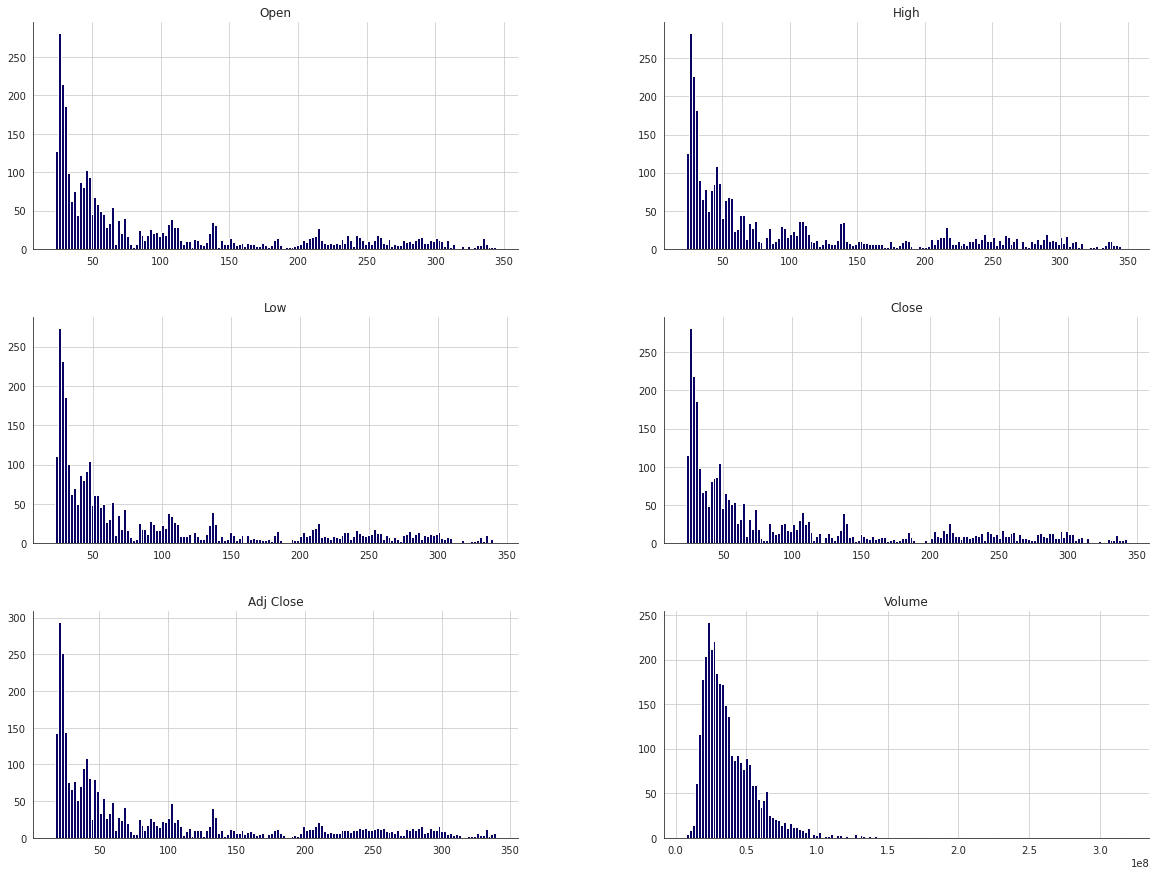

In [61]:
# Plot line charts
df_plot = MSFT.copy()
df_plot.hist(bins=150,figsize=(20,15))
plt.show()

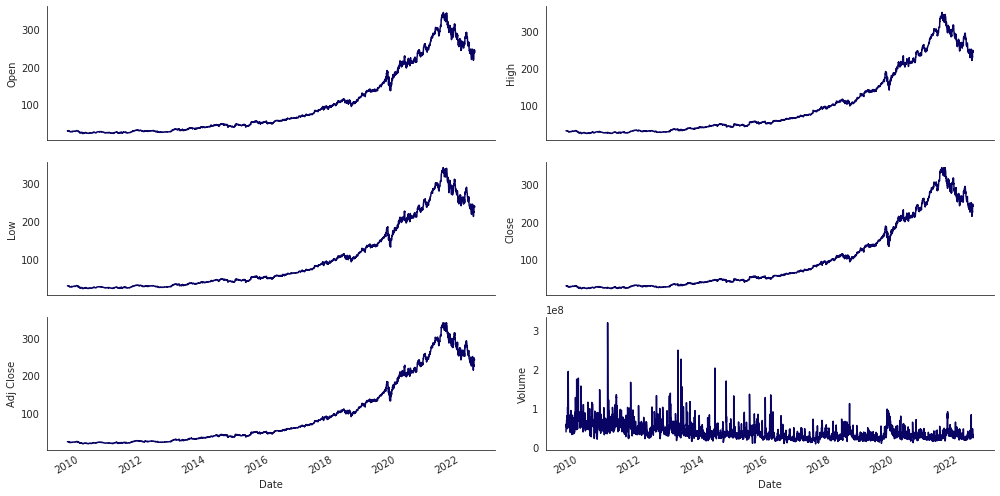

In [62]:
# Plot line charts
df_plot = MSFT.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))

for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

### Data pre-processing

>  we drop Columns Date since this does not give valuable information regarding stock price instead is just a measure of time passsing

> we drop Adjusted close since it is calculated after market closing post divident claculation and is not a continoues flow .



In [63]:
# # Indexing Batches
# train_df = df.sort_values(by=['Date']).copy()
filtered_df = MSFT.sort_values(by=['Date']).copy()
# Removing Adjusted Close Column
filtered_df = filtered_df.drop([ 'Adj Close'], axis=1)
filtered_df['Prediction'] = filtered_df['Close']
# Print the tail of the dataframe
display(filtered_df.tail())

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2022-11-14,241.990005,243.910004,239.210007,241.550003,31123300,241.550003
2022-11-15,245.660004,247.000000,240.029999,241.970001,31390100,241.970001
2022-11-16,242.789993,243.800003,240.419998,241.729996,24093300,241.729996
2022-11-17,237.779999,243.250000,237.630005,241.679993,23123500,241.679993
2022-11-18,243.509995,243.740005,239.029999,241.220001,27591800,241.220001


#Code from classes 

In [64]:
from typing_extensions import Self
class Basenet():

    def __init__(self,index_Close,sequence_length):
        self.train_set = None
        self.val_set = None
        self.test_set = None
        self.index_Close = index_Close
        self.sequence_length = sequence_length
        self.optimizer = None
        self.epoch = None

    def pre_processdata(self,filtered_df):

        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(filtered_df)
        df_Close = pd.DataFrame(filtered_df['Close'])

        scaler_pred = MinMaxScaler()
        np_Close_scaled = scaler_pred.fit_transform(df_Close)
        
        return data_scaled,scaler_pred,df_Close,scaler
        
    def partition_dataset(self,sequence_length, data):
        x, y = [], []
        data_len = data.shape[0]
        for i in range(sequence_length, data_len):
            x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
            y.append(data[i, self.index_Close]) #contains the prediction values for validation,  for single-step prediction
        
        # Convert the x and y to numpy arrays
        x = np.array(x)
        y = np.array(y)
        return x, y

    def split_data(self,stock,splitsize):
        # data_raw = stock.to_numpy() # convert to numpy array
        data = stock.copy()
        #calc test size
        data = np.array(data)
        test_size = int(np.round(len(data)*splitsize))
        bg_train_size = len(data) - test_size
        val_size = int(np.round(bg_train_size*(splitsize/2)))
        train_size = bg_train_size - val_size
        self.train_set = data[:train_size,:]
        self.val_set = data[train_size:bg_train_size,:]
        self.test_set = data[bg_train_size:,:]
        print("Training Size :",len(self.train_set))
        print("Validation Size :",len(self.val_set))
        print("Testing Size :",len(self.test_set))

        sequence_length = self.sequence_length
        x_train,y_train = self.partition_dataset(sequence_length,self.train_set)
        x_val,y_val = self.partition_dataset(sequence_length,self.val_set)
        x_test,y_test = self.partition_dataset(sequence_length,self.val_set)
        # print(f"x_val{x_val.shape},y_val{y_val.shape}")
        print(f"X_Training Shape : {x_train.shape}")
        print(f"y_Training Shape : {y_train.shape}")
        print(f"X_Validation : {x_val.shape}")
        print(f"Y_Validation : {y_val.shape}")
        print(f"X_Testing : {x_test.shape}")
        print(f"Y_Testing : {y_test.shape}")

        return x_train,y_train,x_val,y_val,x_test,y_test


    def train(self,model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size = 16):
        self.epoch = epochs
        # Training the model
        early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

        history = model.fit(x_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                         # )
                            
                            callbacks=[early_stop])
        # Get the predicted values
        y_pred_scaled = model.predict(x_val)

        # Unscale the predicted values
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

        # Plot training & validation loss values
        self.plot_Loss (history)

        return history,y_pred_scaled,y_pred,y_val_unscaled

    def plot_Loss (self, history):
        fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
        val_accuracies = history.history["loss"]
        train_accuracies = history.history["val_loss"]
        plt.plot(np.arange(len(val_accuracies)), val_accuracies, label = "Validation Loss")
        plt.plot(np.arange(len(train_accuracies)), train_accuracies, label = "Training Loss")
        plt.title("Model loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        ax.xaxis.set_major_locator(plt.MaxNLocator(50))
        plt.legend(["Train", "Val"], loc="upper right")
        plt.grid()
        plt.show()

    # def plot_Loss (self,y_val,yval_pred, history):
    #     fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
    #     plt.plot(np.arange(len(y_val)), y_val, label = "Vakidation data")
    #     plt.plot(np.arange(len(yval_pred)), yval_pred, label = "Validation Predictions")
    #     plt.title("Model performance")
    #     plt.ylabel("Loss")
    #     plt.xlabel("Epoch")
    #     ax.xaxis.set_major_locator(plt.MaxNLocator(50))
    #     plt.legend(["Train", "Val"], loc="upper right")
    #     plt.grid()
    #     plt.show()
    

## Vanilla RNN

In [65]:

class V_RNN_cls(Basenet):

  def __init__(self,index_Close,sequence_length):
    super().__init__(index_Close,sequence_length)
    self.x_train = None
    self.y_pred =None


  def VRNN_model(self,x_train,optimizer = 'adam',lr=0.001):
      sequence_length =self.sequence_length
      if optimizer == 'adam':
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      elif optimizer == 'sgd': 
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)
      n_neurons = x_train.shape[1] *x_train.shape[2]

      # initializing the RNN
      regressor = Sequential()

      # adding first RNN layer and dropout regulatization
      regressor.add(
          SimpleRNN(units = n_neurons, 
                    activation = "tanh", 
                    return_sequences = True, 
                    input_shape=(x_train.shape[1],x_train.shape[2]))
                  )

      regressor.add(
          Dropout(0.2)
                  )


      # adding second RNN layer

      regressor.add(
          SimpleRNN(units = n_neurons, 
                    activation = "tanh", 
                    return_sequences = True)
                  )
      # adding third RNN layer 

      regressor.add(
          SimpleRNN(units = n_neurons)
                  )

      #adding the Dense layer
      regressor.add(Dense(5))
      # adding the output layer
      regressor.add(Dense(units = 1))

      # compiling RNN
      regressor.compile(
          optimizer = "adam", 
          loss = "mean_squared_error")

      return regressor


Training Size : 2335
Validation Size : 260
Testing Size : 649
X_Training Shape : (2315, 20, 6)
y_Training Shape : (2315,)
X_Validation : (240, 20, 6)
Y_Validation : (240,)
X_Testing : (240, 20, 6)
Y_Testing : (240,)
Epoch 1/20
78/78 [==============================] - 6s 59ms/step - loss: 0.1625 - val_loss: 0.0167
Epoch 2/20
78/78 [==============================] - 10s 128ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 3/20
78/78 [==============================] - 10s 125ms/step - loss: 0.0023 - val_loss: 6.7072e-04
Epoch 4/20
78/78 [==============================] - 8s 106ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 5/20
78/78 [==============================] - 4s 52ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/20
78/78 [==============================] - 4s 50ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/20
78/78 [==============================] - 4s 51ms/step - loss: 8.5921e-04 - val_loss: 9.6589e-04
Epoch 8/20
78/78 [==============================] - 4s 50ms/step - loss: 9

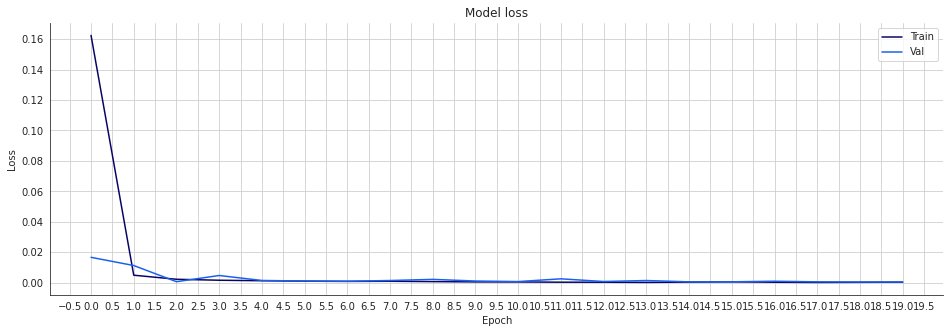

------------------------------------------------------
Median Absolute Error (MAE): 5.07
Mean Absolute Percentage Error (MAPE): 3.37 %
Median Absolute Percentage Error (MDAPE): 2.76 %


In [66]:
optimizer = 'adam'
lr=0.001
batch_size = 30
epochs = 20
index_Close = 3
sequence_length = 20

vrnn = V_RNN_cls(index_Close,sequence_length)
data_scaled,scaler_pred,df_Close,scaler = vrnn.pre_processdata(filtered_df)
x_train,y_train,x_val,y_val,x_test,y_test = vrnn.split_data(data_scaled,.2)

vrnn_model = vrnn.VRNN_model(x_train,optimizer,lr)
history,y_pred_scaled,y_pred,y_val_unscaled = vrnn.train(vrnn_model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size)

# # Plot training & validation loss values
# vrnn.plot_Loss (history)

print("------------------------------------------------------")
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

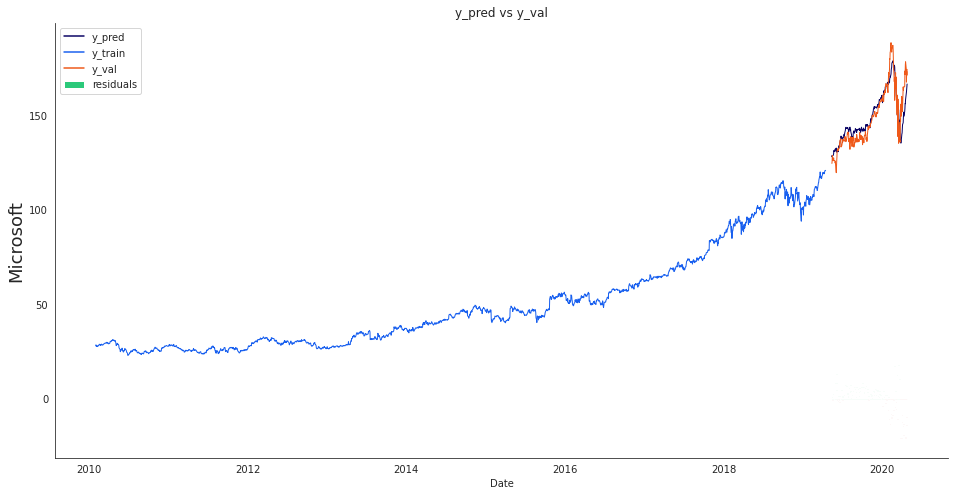

In [67]:
# The date from which on the date is displayed
display_start_date = start_d 
train_data_len = len(vrnn.train_set)
val_data_len = len(vrnn.train_set) + len(vrnn.val_set)
start=int(train_data_len*.95 + vrnn.sequence_length)
# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_Close['Close'][vrnn.sequence_length:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len+vrnn.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_val"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_val")
plt.ylabel("Microsoft", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [68]:
train_data_len*.8

1868.0

In [69]:

df_temp = vrnn.test_set[-vrnn.sequence_length:]
df_temp[-1][3]
N = sequence_length

# # Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = df_temp[-sequence_length:]
# last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(df_temp)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = vrnn_model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
print(f"pred_price_unscaled : {pred_price_unscaled}")
# Print last price and predicted price for the next day
price_today = np.round(df_temp[-1][3],2)
x= scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"price_today : {x}")
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (x * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 19ms/step
pred_price_unscaled : [[224.4943]]
price_today : [[240.67799011]]
The predicted close price is 224.49000549316406 ([[-7.21]]%)


## LSTM

In [70]:

class LSTM_cls(Basenet):

  def __init__(self,index_Close,sequence_length):
    super().__init__(index_Close,sequence_length)
    self.x_train = None
    self.y_pred =None



  def LSTM_model(self,x_train,optimizer = 'adam',lr=0.001):

    sequence_length = self.sequence_length
    if optimizer == 'adam':
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd': 
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

    model = Sequential()
    # Model with n_neurons = inputshape Timestamps, each with self.train_set.shape[2] variables
    n_neurons = x_train.shape[1] * x_train.shape[2]
    # First LSTM layer with Dropout regularisation
    model.add(
        LSTM(
            n_neurons, return_sequences=True, 
             input_shape=(x_train.shape[1],x_train.shape[2]))
        ) 
    model.add(          
                      Dropout(0.2)
                      )
    #adding second LSTM layer 
    model.add(
        LSTM(n_neurons, return_sequences=True)
        )
    #adding third LSTM layer 
    model.add(
        LSTM(n_neurons)
        )
    #adding the Dense layer
    model.add(Dense(5))
    # adding the output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=self.optimizer, loss='mse')
    return model
    

Training Size : 2335
Validation Size : 260
Testing Size : 649
X_Training Shape : (2315, 20, 6)
y_Training Shape : (2315,)
X_Validation : (240, 20, 6)
Y_Validation : (240,)
X_Testing : (240, 20, 6)
Y_Testing : (240,)
Epoch 1/20
78/78 [==============================] - 6s 22ms/step - loss: 6.1743e-04 - val_loss: 5.5896e-04
Epoch 2/20
78/78 [==============================] - 1s 8ms/step - loss: 3.9482e-05 - val_loss: 6.5220e-04
Epoch 3/20
78/78 [==============================] - 1s 9ms/step - loss: 4.1333e-05 - val_loss: 7.2333e-04
Epoch 4/20
78/78 [==============================] - 1s 9ms/step - loss: 5.1825e-05 - val_loss: 6.4986e-04
Epoch 5/20
78/78 [==============================] - 1s 9ms/step - loss: 3.5336e-05 - val_loss: 5.1597e-04
Epoch 6/20
78/78 [==============================] - 1s 9ms/step - loss: 3.6535e-05 - val_loss: 4.6977e-04
Epoch 7/20
78/78 [==============================] - 1s 9ms/step - loss: 3.4847e-05 - val_loss: 4.8249e-04
Epoch 8/20
78/78 [=======================

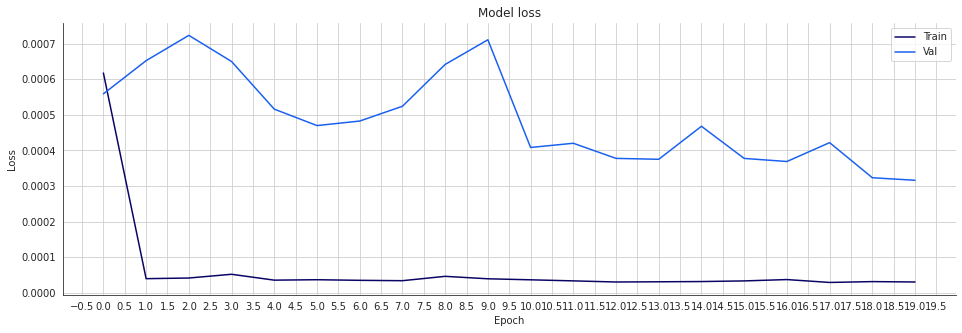

------------------------------------------------------
Median Absolute Error (MAE): 3.73
Mean Absolute Percentage Error (MAPE): 2.44 %
Median Absolute Percentage Error (MDAPE): 1.52 %


In [71]:
optimizer = 'adam'
lr=0.001
batch_size = 30
epochs = 20
index_Close = 3
sequence_length = 20

lstm = LSTM_cls(index_Close,sequence_length)
data_scaled,scaler_pred,df_Close,scaler = lstm.pre_processdata(filtered_df)
x_train,y_train,x_val,y_val,x_test,y_test = lstm.split_data(data_scaled,.2)
lstm_model = lstm.LSTM_model(x_train,optimizer,lr)
history,y_pred_scaled,y_pred,y_val_unscaled = lstm.train(lstm_model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size)


print("------------------------------------------------------")
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

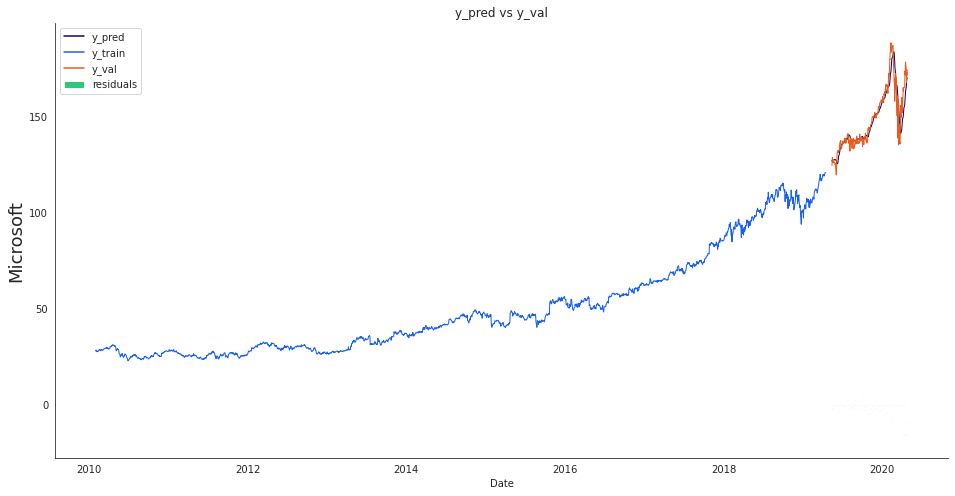

In [72]:
# The date from which on the date is displayed
display_start_date = start_d
train_data_len = len(lstm.train_set)
val_data_len = len(lstm.train_set) + len(lstm.val_set)
start=int(train_data_len*.95 + lstm.sequence_length)
# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_Close['Close'][lstm.sequence_length:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len+lstm.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_val"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_val")
plt.ylabel("Microsoft", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [73]:

df_temp = lstm.test_set[-lstm.sequence_length:]
df_temp[-1][3]
N = sequence_length

# # Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = df_temp[-sequence_length:]
# last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(df_temp)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = lstm_model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
print(f"pred_price_unscaled : {pred_price_unscaled}")
# Print last price and predicted price for the next day
price_today = np.round(df_temp[-1][3],2)
x= scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"price_today : {x}")
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (x * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 24ms/step
pred_price_unscaled : [[235.32928]]
price_today : [[240.67799011]]
The predicted close price is 235.3300018310547 ([[-2.27]]%)


## GRU 

In [74]:
class GRU_cls(Basenet):

  def __init__(self,index_Close,sequence_length):
    super().__init__(index_Close,sequence_length)
    self.x_train = None
    self.y_pred =None

  def GRU_model(self,x_train,optimizer = 'adam',lr=0.001):
    sequence_length =self.sequence_length

    if optimizer == 'adam':
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'sgd': 
      self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

    n_neurons = x_train.shape[1] * x_train.shape[2]
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(
        GRU(units=n_neurons, return_sequences=True, 
            input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh')
        )
    my_GRU_model.add(          
                      Dropout(0.2)
                      )
    #adding second GRU layer 
    my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
    # my_GRU_model.add(          
    #                   Dropout(0.2)
    #                   )
    # adding third RNN layer 
    my_GRU_model.add(GRU(units=n_neurons, activation='tanh'))
    # my_GRU_model.add(          
    #                   Dropout(0.2)
    #                   )
    #adding the Dense layer
    my_GRU_model.add(Dense(units = 5))
    # adding the output layer
    my_GRU_model.add(Dense(units = 1))
    # Compile the model
    my_GRU_model.compile(optimizer=self.optimizer, loss='mse')
    print(f"{n_neurons} = {x_train.shape[1]} * {x_train.shape[2]}")
    return my_GRU_model


Training Size : 2335
Validation Size : 260
Testing Size : 649
X_Training Shape : (2315, 20, 6)
y_Training Shape : (2315,)
X_Validation : (240, 20, 6)
Y_Validation : (240,)
X_Testing : (240, 20, 6)
Y_Testing : (240,)
120 = 20 * 6
Epoch 1/20
78/78 [==============================] - 6s 25ms/step - loss: 5.6339e-04 - val_loss: 2.8450e-04
Epoch 2/20
78/78 [==============================] - 1s 8ms/step - loss: 3.7832e-05 - val_loss: 2.7145e-04
Epoch 3/20
78/78 [==============================] - 1s 8ms/step - loss: 3.1478e-05 - val_loss: 3.3215e-04
Epoch 4/20
78/78 [==============================] - 1s 8ms/step - loss: 2.7685e-05 - val_loss: 2.2439e-04
Epoch 5/20
78/78 [==============================] - 1s 9ms/step - loss: 2.7746e-05 - val_loss: 2.8969e-04
Epoch 6/20
78/78 [==============================] - 1s 8ms/step - loss: 4.1129e-05 - val_loss: 6.5572e-04
Epoch 7/20
78/78 [==============================] - 1s 8ms/step - loss: 3.2104e-05 - val_loss: 3.1244e-04
Epoch 8/20
78/78 [==========

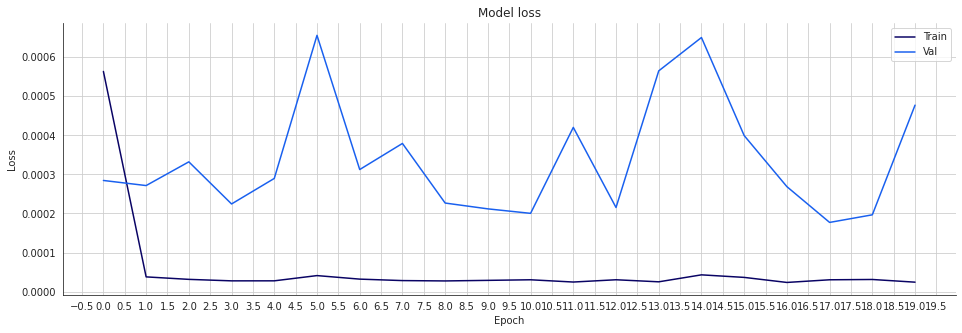

Median Absolute Error (MAE): 5.86
Mean Absolute Percentage Error (MAPE): 4.0 %
Median Absolute Percentage Error (MDAPE): 3.6 %


In [75]:
optimizer = 'adam'
lr=0.001
batch_size = 30
epochs = 20
index_Close = 3
sequence_length = 20


gru = GRU_cls(index_Close,sequence_length)
data_scaled,scaler_pred,df_Close,scaler = gru.pre_processdata(filtered_df)
x_train,y_train,x_val,y_val,x_test,y_test = gru.split_data(data_scaled,.2)

gru_model = gru.GRU_model(x_train,optimizer,lr)
history,y_pred_scaled,y_pred,y_val_unscaled = gru.train(gru_model,epochs,x_train,y_train,x_val,y_val,scaler_pred,batch_size)

# # Plot training & validation loss values
# gru.plot_Loss (history)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

In [76]:

df_temp = gru.test_set[-gru.sequence_length:]
df_temp[-1][3]
N = sequence_length

# # Get the last N day closing price values and scale the data to be values between 0 and 1
# last_N_days = df_temp[-sequence_length:]
# last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(df_temp)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = gru_model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
print(f"pred_price_unscaled : {pred_price_unscaled}")
# Print last price and predicted price for the next day
price_today = np.round(df_temp[-1][3],2)
x= scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"price_today : {x}")
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (x * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 17ms/step
pred_price_unscaled : [[251.21465]]
price_today : [[240.67799011]]
The predicted close price is 251.2100067138672 (+[[4.19]]%)


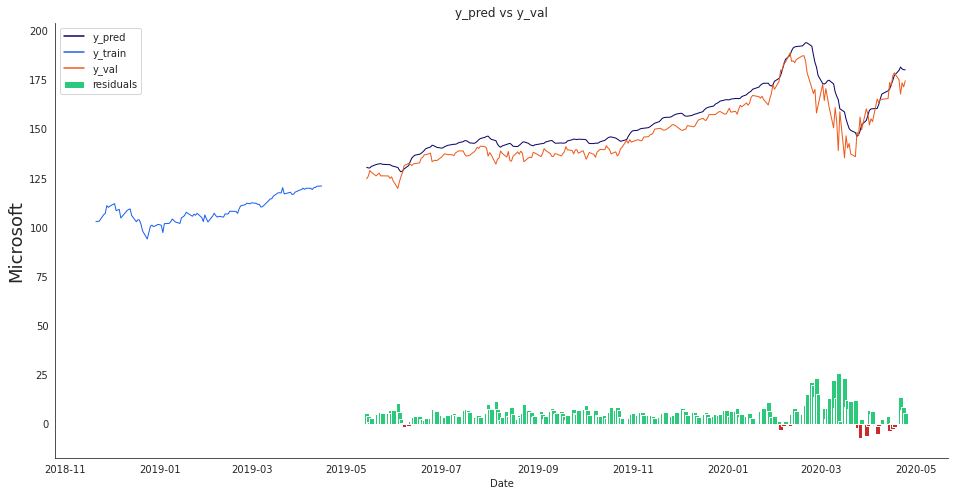

In [77]:
# The date from which on the date is displayed
display_start_date = start_d 
train_data_len = len(gru.train_set)
val_data_len = len(gru.train_set) + len(gru.val_set)
start=int(train_data_len*.95 + gru.sequence_length)
# Add the difference between the valid and predicted prices
train = pd.DataFrame(df_Close['Close'][start:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len+gru.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_val"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_val")
plt.ylabel("Microsoft", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

## Baseline

In [109]:
degree=6
from sklearn.pipeline import Pipeline

In


In [110]:
poly_features = poly.fit(gru.train_set)

from sklearn.linear_model import LinearRegression
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features,yt)

y_predicted = poly.predict(gru.test_set)

ValueError: ignored

# Deleted Stuff

In [78]:
  # def VRNN_model(self,x_train,optimizer = 'adam',lr=0.001):
  #   sequence_length =self.sequence_length

  #   if optimizer == 'adam':
  #     self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  #   elif optimizer == 'sgd': 
  #     self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)
  #   n_neurons = x_train.shape[1] * x_train.shape[2]
  #   # initializing the RNN
  #   regressor = Sequential()

  #   # adding first RNN layer and dropout regulatization
  #   regressor.add(
  #       SimpleRNN(units = n_neurons, 
  #                 activation = "tanh", 
  #                 return_sequences = True, 
  #                 input_shape=(x_train.shape[1], x_train.shape[2]))
  #               )

  #   regressor.add(
  #       Dropout(0.2)
  #               )


  #   # adding second RNN layer and dropout regulatization

  #   regressor.add(
  #       SimpleRNN(units = n_neurons, 
  #                 activation = "tanh", 
  #                 return_sequences = True)
  #               )

  #   regressor.add(
  #       Dropout(0.2)
  #               )

  #   # adding third RNN layer and dropout regulatization

  #   regressor.add(
  #       SimpleRNN(units = n_neurons, 
  #                 activation = "tanh", 
  #                 return_sequences = True)
  #               )

  #   regressor.add(
  #       Dropout(0.2)
  #               )

  #   # adding fourth RNN layer and dropout regulatization

  #   regressor.add(
  #       SimpleRNN(units = n_neurons)
  #               )

  #   regressor.add(
  #       Dropout(0.2)
  #               )
  #   # adding the output layer
  #   regressor.add(Dense(units = 1))

  #   # compiling RNN
  #   regressor.compile(
  #       optimizer = "adam", 
  #       loss = "mean_squared_error")

  #   return regressor

  #     def GRU_model(self,x_train,optimizer = 'adam',lr=0.001):
  #   sequence_length =self.sequence_length

  #   if optimizer == 'adam':
  #     self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  #   elif optimizer == 'sgd': 
  #     self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

  #   n_neurons = x_train.shape[1] * x_train.shape[2]
  #   my_GRU_model = Sequential()
  #   # First GRU layer with Dropout regularisation
  #   my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
  #   my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
  #   my_GRU_model.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
  #   my_GRU_model.add(GRU(units=n_neurons, activation='tanh'))
  #   my_GRU_model.add(Dense(units=1))
    
  #   # Compile the model
  #   my_GRU_model.compile(optimizer=self.optimizer, loss='mse')
  #   return my_GRU_model


    # def LSTM_model(self,x_train,optimizer = 'adam',lr=0.001):
    # sequence_length = self.sequence_length
    # if optimizer == 'adam':
    #   self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # elif optimizer == 'sgd': 
    #   self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

    # model = Sequential()
    # # Model with n_neurons = inputshape Timestamps, each with self.train_set.shape[2] variables
    # n_neurons = x_train.shape[1] * x_train.shape[2]
    
    # model.add(
    #     LSTM(
    #         n_neurons, return_sequences=True, 
    #          input_shape=(x_train.shape[1],x_train.shape[2]))
    #     ) 
    # model.add(
    #     LSTM(n_neurons, return_sequences=False)
    #     )
    # model.add(Dense(5))
    # model.add(Dense(1))

    # # Compile the model
    # model.compile(optimizer=self.optimizer, loss='mse')
    # return model

# df_temp = gru.test_set[-gru.sequence_length:]
# df_temp[-1][3]
# N = sequence_length

# # # Get the last N day closing price values and scale the data to be values between 0 and 1
# # last_N_days = df_temp[-sequence_length:]
# # last_N_days_scaled = scaler.transform(last_N_days)

# # Create an empty list and Append past N days
# X_test_new = []
# X_test_new.append(df_temp)

# # Convert the X_test data set to a numpy array and reshape the data
# pred_price_scaled = gru_model.predict(np.array(X_test_new))
# pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
# print(f"pred_price_unscaled : {pred_price_unscaled}")
# # Print last price and predicted price for the next day
# price_today = np.round(df_temp[-1][3],2)
# x= scaler_pred.inverse_transform(price_today.reshape(-1, 1))
# print(f"price_today : {x}")
# predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
# change_percent = np.round(100 - (x * 100)/predicted_price, 2)

# plus = '+'; minus = ''
# print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

    